In [1]:
code = 'AAPL'

In [2]:
#
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

In [3]:
#
df =pd.read_csv(code+".csv", header=0)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-12,45.072498,45.597500,45.052502,45.430000,43.309387,128828400
1,2018-03-13,45.647499,45.875000,44.810001,44.992500,42.892307,126774000
2,2018-03-14,45.080002,45.130001,44.452499,44.610001,42.527645,117473600
3,2018-03-15,44.625000,45.060001,44.517502,44.662498,42.577709,90975200
4,2018-03-16,44.662498,44.779999,44.404999,44.505001,42.427559,157618800


In [4]:
df = df[-500:]

In [5]:
#size of the dataset
print(df.shape)

(500, 7)


In [6]:
# finind the length of time series
print(len(df.Date.values))

500


In [7]:
#gives the details of each columns of the dataset like mean, max etc
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,500.000000,500.000000,500.000000,500.000000,500.000000,5.000000e+02
mean,149.208120,151.051160,147.532700,149.366480,148.466424,8.517613e+07
std,14.544200,14.726285,14.317919,14.536855,14.547486,2.519262e+07
min,119.540001,120.400002,118.860001,119.900002,118.473900,3.519590e+07
25%,139.899994,142.104996,137.862495,140.057499,139.555416,6.803278e+07
50%,148.330002,149.800003,146.849999,148.580002,147.642754,7.994805e+07
75%,159.609997,162.180000,156.795002,159.345001,158.433671,9.604302e+07
max,182.630005,182.940002,179.119995,182.009995,180.683868,1.954327e+08


In [8]:
#checking whether their is any null value in the dataset
# .sum() will give the total no. of null value column vise 
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

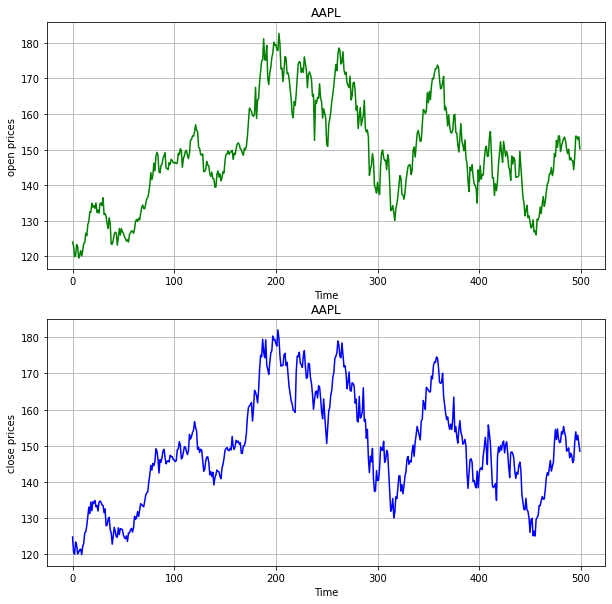

In [9]:
f, axs = plt.subplots(2,2,figsize=(10,10))
plt.subplot(2,1,1)
open = df.Open.values.astype('float32')


plt.grid(True)
plt.xlabel('Time') 
plt.ylabel("open prices")
plt.title(code)
plt.plot(open , 'g') 
    
    
plt.subplot(2,1,2)
close = df.Close.values.astype('float32')


plt.xlabel('Time') 
plt.ylabel("close prices")
plt.title(code) 
plt.grid(True)
plt.plot(close , 'b')
plt.show()

In [10]:
#taking the values of closing_stock in a single list called stocks
stocks = close[:]
#print(stocks)
#reshaping the stocks in 1D array form
stocks = stocks.reshape(len(stocks) , 1)

In [11]:
# **Feature scaling the vector for better model performance.**
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)) #scaling features between 0 and 1
stocks = scaler.fit_transform(stocks) # it will start learning algo and then provide scaled and dimension reduced output

In [12]:
train = int(len(stocks) * 0.80) #creating sizes of train and taking 80% percentage of the part
test = len(stocks) - train #creating sizes of test as total minus train

In [13]:
#sizes of train and test
print(train , test)

400 100


In [14]:
#divinding the values of stocks data to train from 0 to  80% data
train = stocks[0:train]
#print(train)

In [15]:
#divinding the values of stocks data to test from train ending to stock data ending i.e rest 20% data
test = stocks[len(train) : ]

In [16]:
#reshaping train data in 1D array form
train = train.reshape(len(train) , 1)
#reshaping test data in 1D array form
test = test.reshape(len(test) , 1)

In [17]:
#new train and test array shape
print(train.shape , test.shape)

(400, 1) (100, 1)


In [18]:
#creating function to create trainX,testX and target(trainY, testY)
def process_data(data , n_features):
    dataX, dataY = [], [] 
    for i in range(len(data)-n_features-1):
        a = data[i:(i+n_features), 0]
        dataX.append(a) 
        dataY.append(data[i + n_features, 0])
        
    return np.array(dataX), np.array(dataY)

#so the stucture of trainX and trainY is somehow like this
# trainX=[[i1 , i2,...., i n_features ]] and trainY=[i + n_features]  
# trainY will show the future value of trainX values

In [19]:
n_features = 2
trainX, trainY = process_data(train, n_features)
testX, testY = process_data(test, n_features)

In [20]:
# printing the structure of train X,Y and test X,Y
print(trainX.shape , trainY.shape , testX.shape , testY.shape)

(397, 2) (397,) (97, 2) (97,)


In [21]:
# reshaping trainX and testX to use in deeplearning model
trainX = trainX.reshape(trainX.shape[0] , 1 ,trainX.shape[1])
testX = testX.reshape(testX.shape[0] , 1 ,testX.shape[1])

In [22]:
import math 
from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation # types of layers
from keras.layers import LSTM , GRU 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error 
from keras.optimizers import Adam , SGD , RMSprop 

In [23]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

In [24]:
filepath="stock_weights1.hdf5"
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

In [25]:
# creating model for training data using sequential to give series wise output between layers
model = Sequential()

model.add(GRU(256 , input_shape = (1 , n_features) , return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(256))
model.add(Dropout(0.4))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 256)            199680    
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 741,505
Trainable params: 741,505
Non-trai

In [26]:
# selecting the loss measurement metrics and optimizer for our model , to find out mean square error
model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.0005) , metrics = ['mean_squared_error'])

In [27]:
# fitting the data i.e training the trainX, to relate to trainY
history = model.fit(trainX, trainY, epochs=100 , batch_size = 128 , 
          callbacks = [checkpoint , lr_reduce] , validation_data = (testX,testY))    
#callbacks are proper

Epoch 1/100
1/4 [======>.......................] - ETA: 13s - loss: 0.2934 - mean_squared_error: 0.2934
Epoch 1: val_loss improved from -inf to 0.13353, saving model to stock_weights1.hdf5
4/4 [==============================] - 6s 407ms/step - loss: 0.3008 - mean_squared_error: 0.3008 - val_loss: 0.1335 - val_mean_squared_error: 0.1335 - lr: 5.0000e-04
Epoch 2/100
1/4 [======>.......................] - ETA: 0s - loss: 0.2634 - mean_squared_error: 0.2634
Epoch 2: val_loss did not improve from 0.13353
4/4 [==============================] - 0s 29ms/step - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.1012 - val_mean_squared_error: 0.1012 - lr: 5.0000e-04
Epoch 3/100
1/4 [======>.......................] - ETA: 0s - loss: 0.2178 - mean_squared_error: 0.2178
Epoch 3: val_loss did not improve from 0.13353
4/4 [==============================] - 0s 28ms/step - loss: 0.1941 - mean_squared_error: 0.1941 - val_loss: 0.0659 - val_mean_squared_error: 0.0659 - lr: 5.0000e-04
Epoch 4/100
1/4

In [28]:
#predicting the value for testX
pred = model.predict(testX)
pred = scaler.inverse_transform(pred)
pred[:5]
# taking pred from 1 to 10

4/4 [==============================] - 1s 5ms/step


array([[149.22713],
       [149.76671],
       [149.67572],
       [150.5941 ],
       [152.69464]], dtype=float32)

In [29]:
# reshaping testY in single array
testY = testY.reshape(testY.shape[0] , 1)
testY = scaler.inverse_transform(testY)
testY[:5]

array([[143.86],
       [143.39],
       [147.27],
       [149.45],
       [152.34]], dtype=float32)

Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices


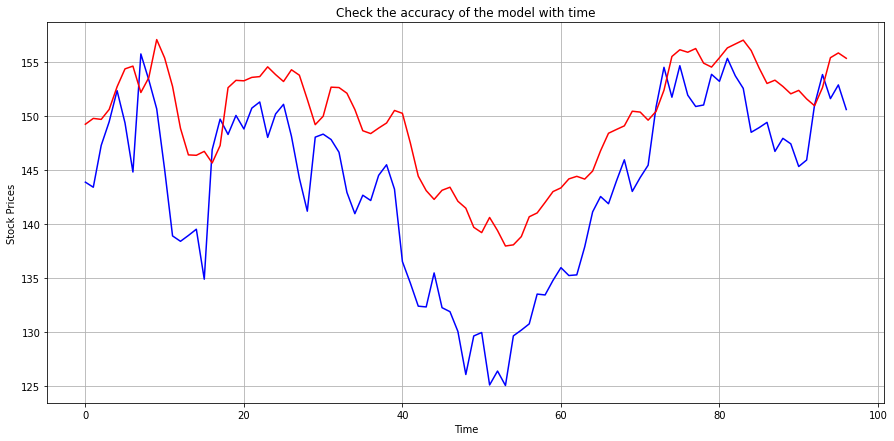

In [30]:
# ploting the graph of stock prices with time
print("Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices")
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(testY , 'b')
plt.plot(pred , 'r')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.title('Check the accuracy of the model with time')
plt.grid(True)
plt.show()

In [31]:
#predicting the value for testX
pred = model.predict(trainX)
pred = scaler.inverse_transform(pred)
pred[:5]
# taking pred from 1 to 10

13/13 [==============================] - 0s 4ms/step


array([[136.2503 ],
       [134.56956],
       [135.28842],
       [136.29501],
       [135.32481]], dtype=float32)

Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices


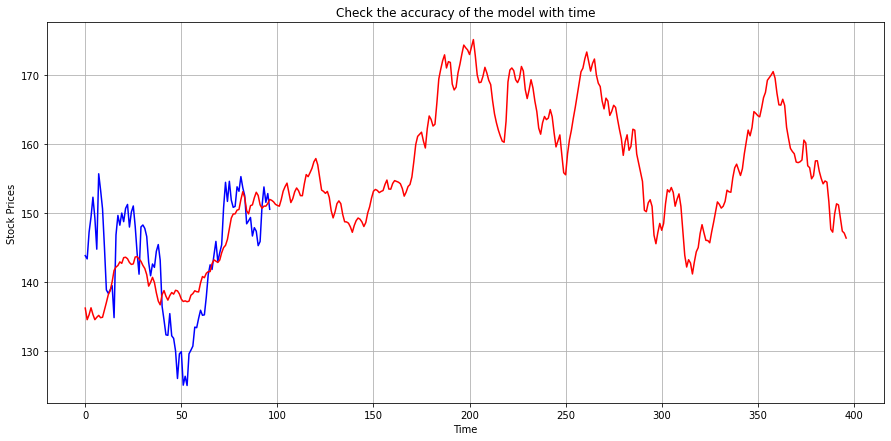

In [32]:
# ploting the graph of stock prices with time
print("Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices")
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(testY , 'b')
plt.plot(pred , 'r')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.title('Check the accuracy of the model with time')
plt.grid(True)
plt.show()